In [1]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

In [2]:
import mlflow
import mlflow.pytorch

In [3]:
get_ipython().system_raw("mlflow ui --port 5000 &")
mlflow.pytorch.autolog()

/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
2024-04-10 17:39:53.147802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 17:39:53.147904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 17:39:53.313214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[2024-04-10 17:39:54 +0000] [93] [INFO] Starting gunicorn 21.2.0
[2024-04-10 17:39:54 +0000] [93] [INFO] Listening at: http://127.0.0.1:5000 (93

In [4]:
from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2efJXrwFsv10TFSG3PqZhzNttQd_5GPgBrnz7twqaRrJkJm21"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://5d51-34-132-223-143.ngrok-free.app                                      


In [6]:
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torchinfo import summary
from torchvision import datasets
from torchvision import models
from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as F

torch.set_default_device('cuda')

In [191]:
mlflow.set_tracking_uri(ngrok_tunnel.public_url)
mlflow.set_experiment("corn-maize-disease-HP-tuning")

<Experiment: artifact_location='mlflow-artifacts:/450580551926357218', creation_time=1712289935971, experiment_id='450580551926357218', last_update_time=1712289935971, lifecycle_stage='active', name='corn-maize-disease-HP-tuning', tags={'mlflow.sharedViewState.d93c0a209d9781f6e83f1ed24c6510c8c8269e7c29dd2ec43977c7e913ffcb05': '{"searchFilter":"","orderByKey":"attributes.start_time","orderByAsc":false,"startTime":"ALL","lifecycleFilter":"Active","datasetsFilter":[],"modelVersionFilter":"All '
                                                                                            'Runs","selectedColumns":["attributes.`Source`","attributes.`Models`","attributes.`Dataset`"],"runsExpanded":{},"runsPinned":[],"runsHidden":[],"runsHiddenMode":"FIRST_10_RUNS","compareRunCharts":[{"uuid":"1712294162301ffwi64r8","type":"BAR","runsCountToCompare":10,"metricSectionId":"1712294063379kf2hf894","deleted":true,"isGenerated":true,"metricKey":"0_f1_score"},{"uuid":"17122941623013nxggoyk","type":"BAR

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
import gc

gc.collect()

12

In [9]:
def tv_split(dataset, split_size=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=split_size)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['validation'] = torch.utils.data.Subset(dataset, val_idx)
    return datasets

In [10]:
transform = transforms.Compose(
    [transforms.Resize((300, 300)), transforms.ToTensor(), transforms.RandomHorizontalFlip(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
traindata = datasets.ImageFolder("/kaggle/input/corn-or-maize-leaf-disease-dataset/data", transform=transform)
validdata = datasets.ImageFolder("/kaggle/input/corn-or-maize-leaf-disease-dataset/data", transform=transform)

dataset = tv_split(traindata)
trainloader = torch.utils.data.DataLoader(dataset['train'], batch_size=60, shuffle=True,generator=torch.Generator(device='cuda') )
test_data = tv_split(dataset['validation'], 0.50)
validationloader = torch.utils.data.DataLoader(test_data['train'], batch_size=60, shuffle=False,
                                               generator=torch.Generator(device='cuda'))
testloader = torch.utils.data.DataLoader(test_data['validation'], batch_size=15, shuffle=False,
                                         generator=torch.Generator(device='cuda'))

loader = {'train': trainloader, 'validation': validationloader}
classes = ["blight", "common_rust", "gray_leaf_spot", "healthy"]

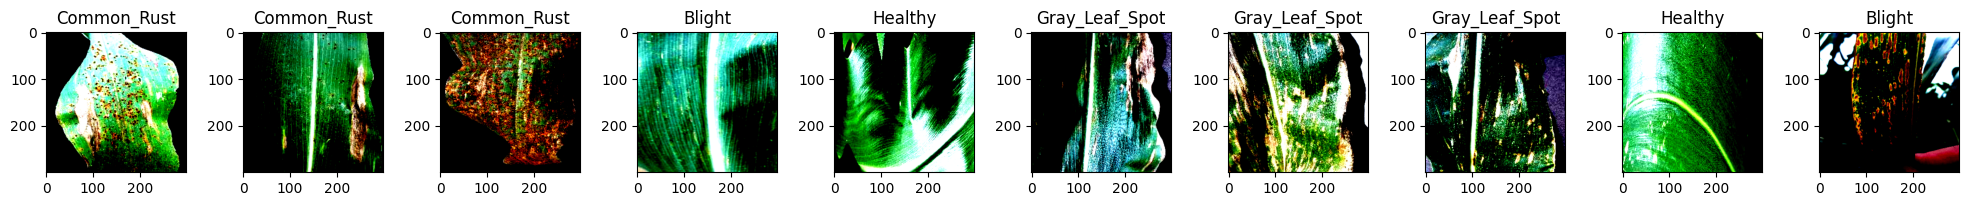

In [196]:
def im_convert(tensor):
    img = tensor.clone().detach().numpy()
    img = img.transpose(1, 2, 0)
    # img = img*np.array(([0.485, 0.456, 0.406])/np.array(([0.229, 0.224, 0.225])))
    return img


dataiter = iter(trainloader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))
for i in np.arange(10):
    ax = fig.add_subplot(2, 10, i + 1)
    plt.imshow(im_convert(images[i]))
    ax.set_title(traindata.classes[labels[i].item()])


In [12]:
model = models.inception_v3();

/opt/conda/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [13]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, len(traindata.classes))
model = model.to(device)

In [14]:
loss_fn = nn.CrossEntropyLoss()

In [199]:
def train(model, epochs, learning_rate, loss_fn):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    running_loss_history = []
    val_running_loss_historu = []
    running_loss_correct = []
    val_running_loss_correct = []
    val_features = []
    val_labels_arr = []
    for i in range(epochs):
        running_loss = 0.0
        val_running_loss = 0.0

        running_correct = 0.0
        val_running_correct = 0.0

        for inputs, labels in trainloader:
            encoder = OneHotEncoder(sparse_output=False)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs,_ = model(inputs)
            optimizer.zero_grad()
#             loss = loss_fn(outputs, labels)
            loss = loss_fn(F.log_softmax(outputs, dim=1), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, pred = torch.max(outputs, 1)
            running_correct += torch.sum(pred == labels.data)

        else:
            with torch.no_grad():
                for val_inputs, val_labels in validationloader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs, _ = model(val_inputs)
                    val_features.extend(val_outputs.data.cpu().numpy())
                    val_labels_arr.extend(val_labels.data.cpu().numpy())
#                     val_loss = loss_fn(val_outputs, val_labels)
                    val_loss = loss_fn(F.log_softmax(val_outputs, dim=1), val_labels)
                    _, val_pred = torch.max(val_outputs, 1)
                    val_running_correct += torch.sum(val_pred == val_labels.data)
                    val_running_loss += val_loss.item() * val_inputs.size(0)
            val_epoch_accuracy = val_running_correct.float() / len(validationloader.dataset)
            val_epoch_loss = val_running_loss / len(validationloader.dataset)
            val_running_loss_historu.append(val_epoch_loss)
            val_running_loss_correct.append(val_epoch_accuracy)

            epoch_accuracy = running_correct.float() / len(trainloader.dataset)

            epoch_loss = running_loss / len(trainloader.dataset)
            running_loss_history.append(epoch_loss)
            running_loss_correct.append(epoch_accuracy)
            mlflow.log_metric("train_loss", f"{epoch_loss:2f}", step=i)
            mlflow.log_metric("train_accuracy", f"{epoch_accuracy.item():2f}", step=i)
            mlflow.log_metric("val_loss", f"{val_epoch_loss:2f}", step=i)
            mlflow.log_metric("val_accuracy", f"{val_epoch_accuracy.item():2f}", step=i)
            print("Epoch:{}".format(i))
            print("Training loss:{} and Accuracy:{}".format(epoch_loss, epoch_accuracy.item()))
            print("Validation loss: {} and Accuracy:{}".format(val_epoch_loss, val_epoch_accuracy.item()))
    return running_loss_history, val_running_loss_historu, running_loss_correct, val_running_loss_correct, val_features, val_labels_arr

In [200]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


def classification_r():
    y_test, y_pred = [], []
    for images, labels in testloader:
        y_test.extend(labels.data.cpu().numpy())
        images = images.to(device)
        output, _ = model(images)
        _, preds = torch.max(output, 1)
        y_pred.extend(preds.data.cpu().numpy())
    report = classification_report(y_test, y_pred)
    report_lines = report.split('\n')
    print(report_lines)
    for line in report_lines[2:-5]:
        print(line.strip().split())
        metric_name, precision, recall, f1_score, support = line.strip().split()

        mlflow.log_metric(metric_name + '_precision', float(precision))
        mlflow.log_metric(metric_name + '_recall', float(recall))
        mlflow.log_metric(metric_name + '_f1_score', float(f1_score))
        mlflow.log_metric(metric_name + '_support', float(support))
    with open("classification_report.txt", "w") as file:
        file.write(report)

    mlflow.log_artifact("classification_report.txt")

    #Confusion matrix
    cm_plot = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    mlflow.log_figure(cm_plot.figure_, "test confusion matrix.png")

In [201]:
from sklearn.manifold import TSNE

def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings = tsne.fit_transform(features)
    fig = plt.figure(figsize=(10, 8))
    for label in np.unique(labels):
        indices = np.where(np.array(labels) == label)[0]
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=label, alpha=0.5)
    plt.title('t-SNE Visualization of Image Data')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Class')
    plt.show()
    mlflow.log_figure(fig, "tsne_plot.png")

Epoch:0
Training loss:0.0033874355245437195 and Accuracy:0.923283576965332
Validation loss: 0.0035581681744011034 and Accuracy:0.9236277341842651
Epoch:1
Training loss:0.0033889247454814055 and Accuracy:0.9226865172386169
Validation loss: 0.004137966577363754 and Accuracy:0.9212411046028137
Epoch:2
Training loss:0.0030731561413006995 and Accuracy:0.9265671372413635
Validation loss: 0.003696204743265821 and Accuracy:0.9212411046028137
Epoch:3
Training loss:0.002931758783646484 and Accuracy:0.9343283176422119
Validation loss: 0.0034186903360635397 and Accuracy:0.9307876229286194
Epoch:4
Training loss:0.003013637438416481 and Accuracy:0.932238757610321
Validation loss: 0.003582181929119447 and Accuracy:0.9260143637657166
Epoch:5
Training loss:0.0025917107111482476 and Accuracy:0.94149249792099
Validation loss: 0.003766310332356319 and Accuracy:0.9260143637657166
Epoch:6
Training loss:0.0029788316085712233 and Accuracy:0.9328358173370361
Validation loss: 0.0036729033636307092 and Accuracy:

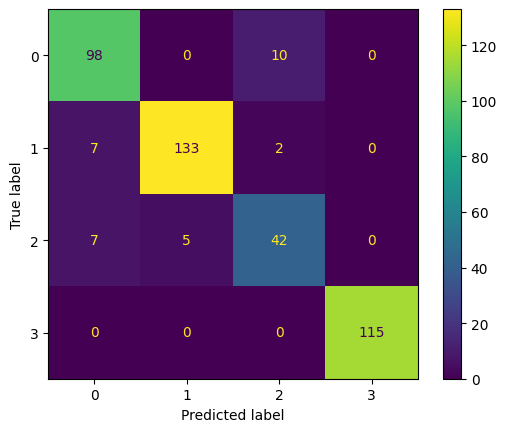

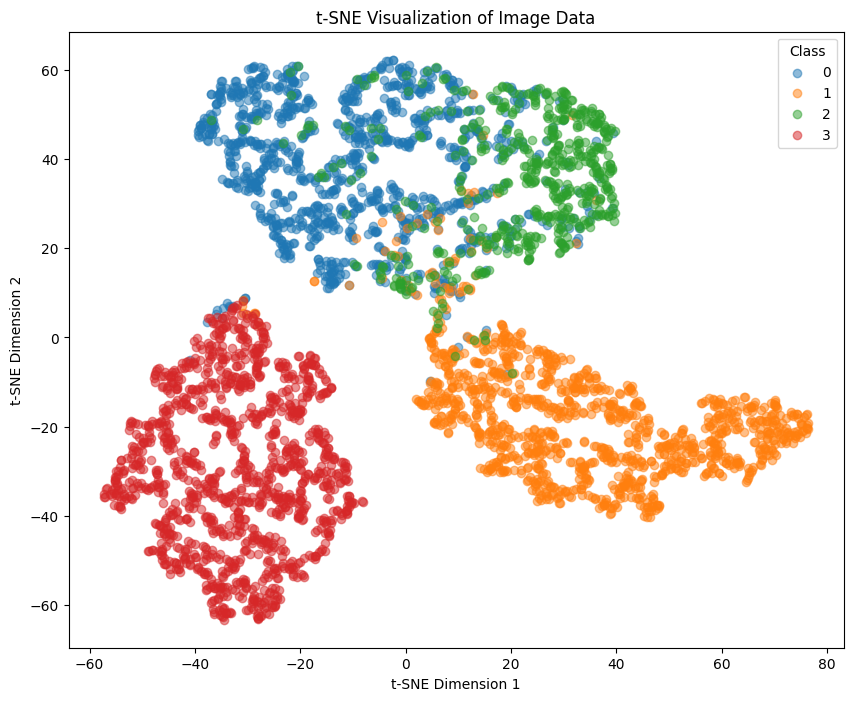

/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Epoch:0
Training loss:0.0017799216642308592 and Accuracy:0.960298478603363
Validation loss: 0.0030792785146071403 and Accuracy:0.9379475116729736
Epoch:1
Training loss:0.0014652607512118212 and Accuracy:0.9689552187919617
Validation loss: 0.0031770587251977304 and Accuracy:0.9355608820915222
Epoch:2
Training loss:0.0015090366263887775 and Accuracy:0.9677611589431763
Validation loss: 0.003227074597217587 and Accuracy:0.9451074600219727
Epoch:3
Training loss:0.0012742014268218582 and Accuracy:0.9734327793121338
Validation loss: 0.003166167043273944 and Accuracy:0.940334141254425
Epoch:4
Training loss:0.001454494453744212 and Accuracy:0.9683581590652466
Validation loss: 0.003076828856172311 and Accuracy:0.9451074600219727
Epoch:5
Training loss:0.0013120462714847343 and Accuracy:0.9716417789459229
Validation loss: 0.0035577188279293033 and Accuracy:0.940334141254425
Epoch:6
Training loss:0.0011379024052797857 and Accuracy:0.9808955192565918
Validation loss: 0.003381027580018829 and Accurac

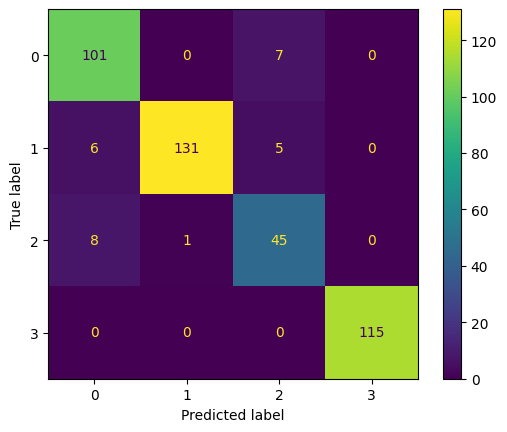

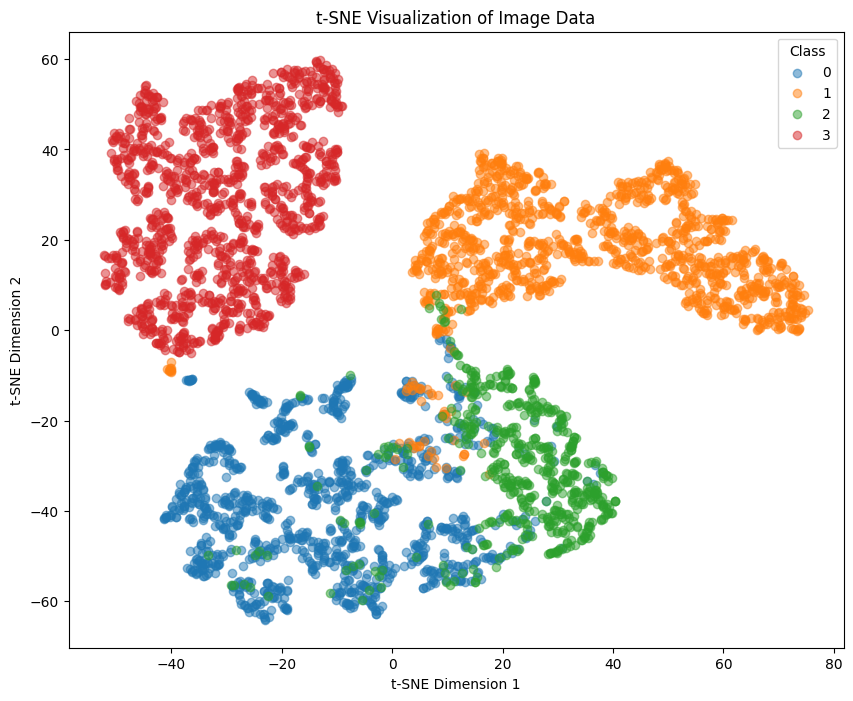

Epoch:0
Training loss:0.0010938757855389544 and Accuracy:0.9785074591636658
Validation loss: 0.003524066333554525 and Accuracy:0.9379475116729736
Epoch:1
Training loss:0.0009527460160428908 and Accuracy:0.9799999594688416
Validation loss: 0.0034324027295613347 and Accuracy:0.9355608820915222
Epoch:2
Training loss:0.0010979023481260484 and Accuracy:0.9799999594688416
Validation loss: 0.003421097993850708 and Accuracy:0.9355608820915222
Epoch:3
Training loss:0.0009739745794725952 and Accuracy:0.9791044592857361
Validation loss: 0.0034939977640468353 and Accuracy:0.9427207708358765
Epoch:4
Training loss:0.000954643343088787 and Accuracy:0.9794029593467712
Validation loss: 0.003141967610840581 and Accuracy:0.9427207708358765
Epoch:5
Training loss:0.000997625630515725 and Accuracy:0.9808955192565918
Validation loss: 0.0031229858253337887 and Accuracy:0.940334141254425
Epoch:6
Training loss:0.0010731437157339124 and Accuracy:0.9791044592857361
Validation loss: 0.003371201366684033 and Accura

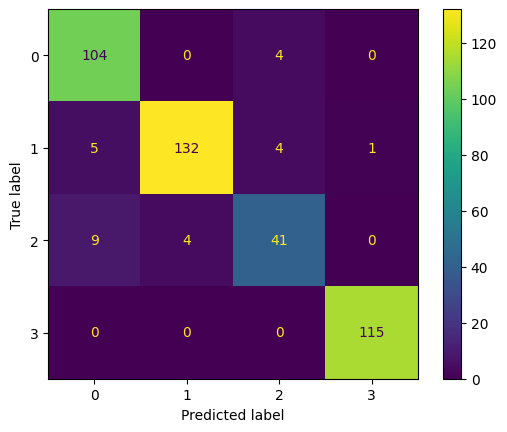

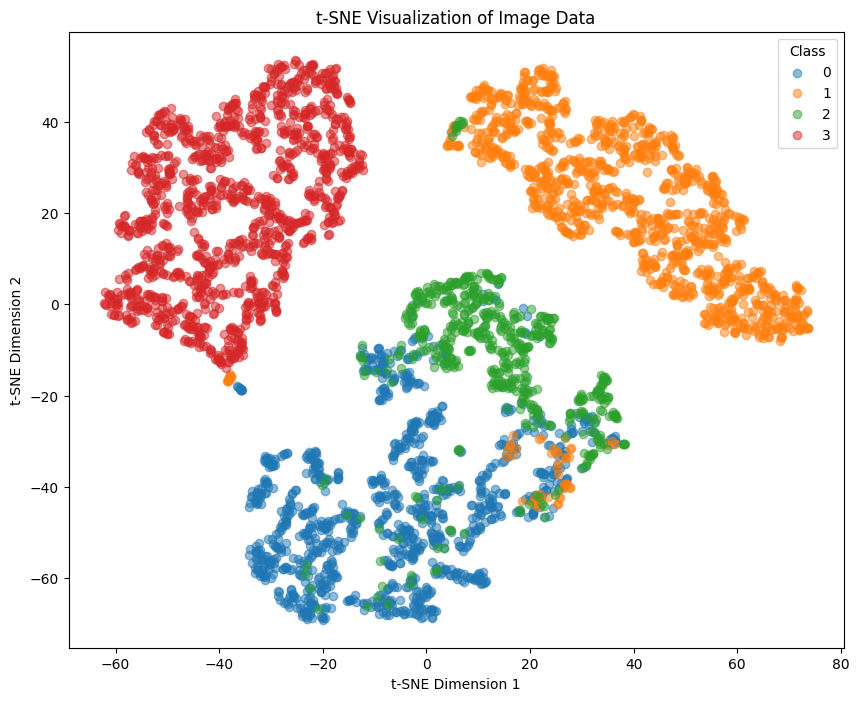

In [148]:
def log_metrics():
    epochs = 10
    lr = [0.1, 0.01, 0.0001]
    for each_lr in lr:
        with mlflow.start_run() as run:
            params = {
                "epochs": epochs,
                "learning_rate": each_lr,
                "batch_size": 60,
                "loss_function": loss_fn.__class__.__name__,
                "optimizer": "SGD",
            }
            mlflow.log_params(params)
            with open("model_summary.txt", "w", encoding="utf-8") as f:
                f.write(str(summary(model)))
            mlflow.log_artifact("model_summary.txt")
            running_loss_history, val_running_loss_historu, running_loss_correct, val_running_loss_correct, val_features, val_labels_arr = train(model, epochs, each_lr, loss_fn)
            classification_r()
            val_features = np.array(val_features)
            plot_tsne(val_features, val_labels_arr)

            mlflow.pytorch.log_model(model, "model")

In [208]:
def log_metrics(loss_fn):
    epochs = 10
    lr = [0.1, 0.01, 0.0001]
    for each_lr in lr:
        with mlflow.start_run() as run:
            params = {
                "epochs": epochs,
                "learning_rate": each_lr,
                "batch_size": 60,
                "loss_function": loss_fn.__class__.__name__,
                "optimizer": "SGD",
            }
            mlflow.log_params(params)
            with open("model_summary.txt", "w", encoding="utf-8") as f:
                f.write(str(summary(model)))
            mlflow.log_artifact("model_summary.txt")
            running_loss_history, val_running_loss_historu, running_loss_correct, val_running_loss_correct, val_features, val_labels_arr = train(model, epochs, each_lr, loss_fn)
            classification_r()
            val_features = np.array(val_features)
            plot_tsne(val_features, val_labels_arr)

#             mlflow.pytorch.log_model(model, "model")

In [209]:
gc.collect()

28076

Epoch:0
Training loss:0.16571810272202564 and Accuracy:0.939104437828064
Validation loss: 0.22206735682089176 and Accuracy:0.9260143637657166
Epoch:1
Training loss:0.15736011591420246 and Accuracy:0.9474626779556274
Validation loss: 0.22184780994007866 and Accuracy:0.9260143637657166
Epoch:2
Training loss:0.14909415302881554 and Accuracy:0.9423880577087402
Validation loss: 0.24399032618023614 and Accuracy:0.9164677858352661
Epoch:3
Training loss:0.1339104437338772 and Accuracy:0.9540297985076904
Validation loss: 0.22949808007350686 and Accuracy:0.9116945266723633
Epoch:4
Training loss:0.12249686093027912 and Accuracy:0.9588059186935425
Validation loss: 0.226715687955763 and Accuracy:0.9260143637657166
Epoch:5
Training loss:0.13180529402930344 and Accuracy:0.9495522379875183
Validation loss: 0.22410553441269584 and Accuracy:0.9355608820915222
Epoch:6
Training loss:0.11143446854913412 and Accuracy:0.9582089185714722
Validation loss: 0.22391730141525906 and Accuracy:0.9307876229286194
Epo

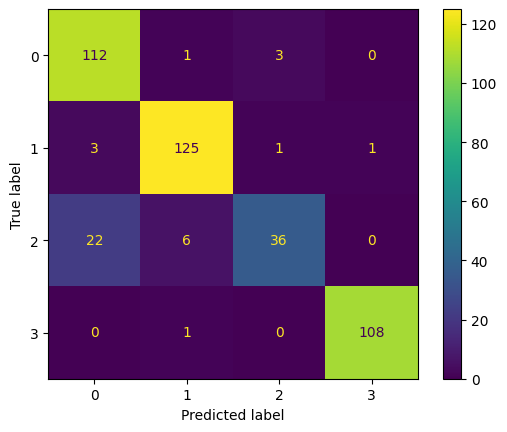

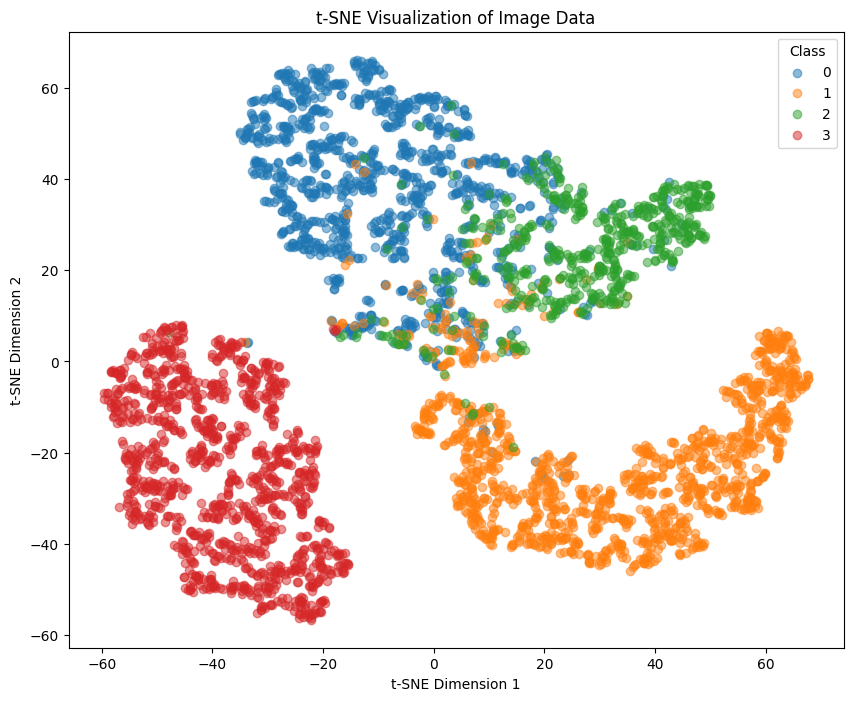

Epoch:0
Training loss:0.07141897791801993 and Accuracy:0.9767163991928101
Validation loss: 0.17711479842733938 and Accuracy:0.9474940896034241
Epoch:1
Training loss:0.06358611803891054 and Accuracy:0.9764178991317749
Validation loss: 0.19006572448624062 and Accuracy:0.9379475116729736
Epoch:2
Training loss:0.056886508799533345 and Accuracy:0.9814925193786621
Validation loss: 0.17299114912748337 and Accuracy:0.9427207708358765
Epoch:3
Training loss:0.05550166283414435 and Accuracy:0.9814925193786621
Validation loss: 0.17273087874232726 and Accuracy:0.9546539783477783
Epoch:4
Training loss:0.05692657080492867 and Accuracy:0.981194019317627
Validation loss: 0.1668877539565 and Accuracy:0.9498807191848755
Epoch:5
Training loss:0.05308158936173613 and Accuracy:0.9853730797767639
Validation loss: 0.1825379938918537 and Accuracy:0.9451074600219727
Epoch:6
Training loss:0.04759775184428514 and Accuracy:0.9844775795936584
Validation loss: 0.17007999918768116 and Accuracy:0.9474940896034241
Epoc

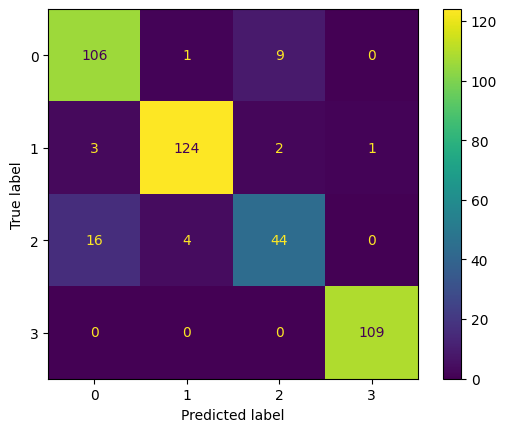

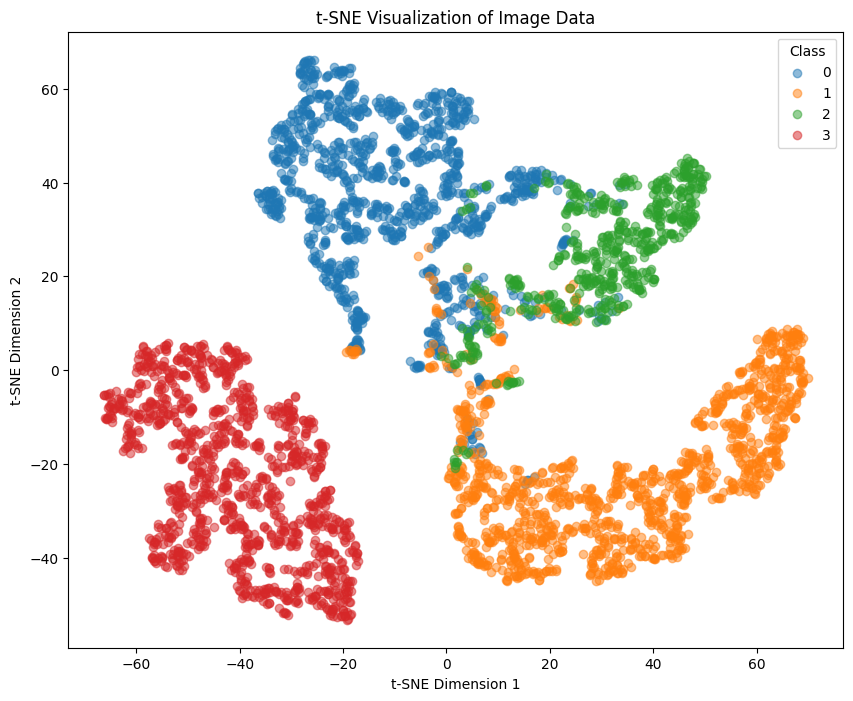

Epoch:0
Training loss:0.0493064658883125 and Accuracy:0.9850745797157288
Validation loss: 0.1978064697582568 and Accuracy:0.9355608820915222
Epoch:1
Training loss:0.037772324091907755 and Accuracy:0.990746259689331
Validation loss: 0.21107708988155557 and Accuracy:0.940334141254425
Epoch:2
Training loss:0.045818651275737074 and Accuracy:0.9826865196228027
Validation loss: 0.20341146995173434 and Accuracy:0.9522673487663269
Epoch:3
Training loss:0.05400917436927557 and Accuracy:0.9823880195617676
Validation loss: 0.18208315733793526 and Accuracy:0.9498807191848755
Epoch:4
Training loss:0.04679641823715239 and Accuracy:0.9844775795936584
Validation loss: 0.19428513451592735 and Accuracy:0.9379475116729736
Epoch:5
Training loss:0.04311596026449506 and Accuracy:0.9862686395645142
Validation loss: 0.19888480466419303 and Accuracy:0.9331742525100708
Epoch:6
Training loss:0.04650336080856288 and Accuracy:0.9841790795326233
Validation loss: 0.2004310902661526 and Accuracy:0.9451074600219727
Ep

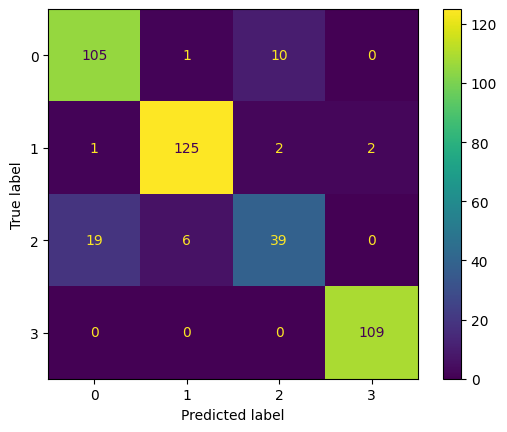

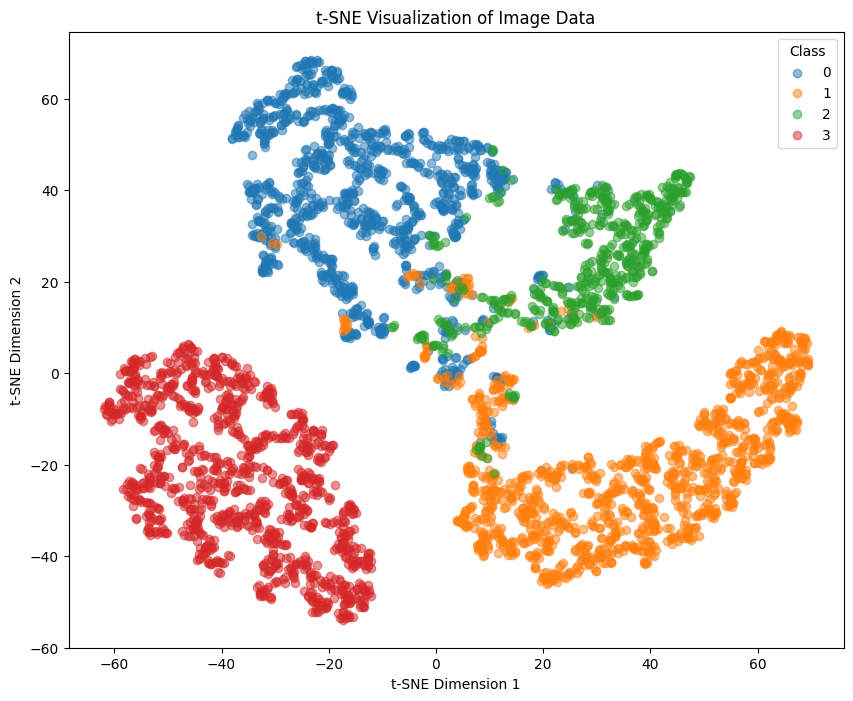

In [210]:
# epochs = 10
# each_lr = 0.01
loss_fn = nn.NLLLoss()
log_metrics(loss_fn)
# running_loss_history, val_running_loss_historu, running_loss_correct, val_running_loss_correct, val_features, val_labels_arr = train(model, epochs, each_lr, loss_fn)

In [205]:
mlflow.end_run()

In [119]:
loss_fn = nn.MSELoss()
log_metrics()

Epoch:0
Training loss:nan and Accuracy:0.25343284010887146
Validation loss: nan and Accuracy:0.25298330187797546


[2024-04-05 20:24:26 +0000] [719] [INFO] Handling signal: int
[2024-04-05 20:24:26 +0000] [722] [INFO] Worker exiting (pid: 722)
[2024-04-05 20:24:26 +0000] [721] [INFO] Worker exiting (pid: 721)
[2024-04-05 20:24:26 +0000] [720] [INFO] Worker exiting (pid: 720)
[2024-04-05 20:24:26 +0000] [723] [INFO] Worker exiting (pid: 723)
[2024-04-05 20:24:26 +0000] [719] [INFO] Shutting down: Master


MlflowException: API request to endpoint /api/2.0/mlflow/runs/update failed with error code 404 != 200. Response body: '<!DOCTYPE html>
<html class="h-full" lang="en-US" dir="ltr">
  <head>
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Regular-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-RegularItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Medium-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Semibold-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-MediumItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/ibm-plex-mono/IBMPlexMono-Text.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/ibm-plex-mono/IBMPlexMono-TextItalic.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/ibm-plex-mono/IBMPlexMono-SemiBold.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/ibm-plex-mono/IBMPlexMono-SemiBoldItalic.woff" as="font" type="font/woff" crossorigin="anonymous" />
    <meta charset="utf-8">
    <meta name="author" content="ngrok">
    <meta name="description" content="ngrok is the fastest way to put anything on the internet with a single command.">
    <meta name="robots" content="noindex, nofollow">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <link id="style" rel="stylesheet" href="https://cdn.ngrok.com/static/css/error.css">
    <noscript>Tunnel 3c03-34-141-202-87.ngrok-free.app not found (ERR_NGROK_3200)</noscript>
    <script id="script" src="https://cdn.ngrok.com/static/js/error.js" type="text/javascript"></script>
  </head>
  <body class="h-full" id="ngrok">
    <div id="root" data-payload="eyJjZG5CYXNlIjoiaHR0cHM6Ly9jZG4ubmdyb2suY29tLyIsImNvZGUiOiIzMjAwIiwibWVzc2FnZSI6IlR1bm5lbCAzYzAzLTM0LTE0MS0yMDItODcubmdyb2stZnJlZS5hcHAgbm90IGZvdW5kIiwidGl0bGUiOiJOb3QgRm91bmQifQ=="></div>
  </body>
</html>
'

In [92]:
# data = np.array([1,1,1,2])
print("\nOne-hot encoded labels:")
en = encoder.fit_transform(labels)
print(en.shape)


One-hot encoded labels:
(60, 4)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


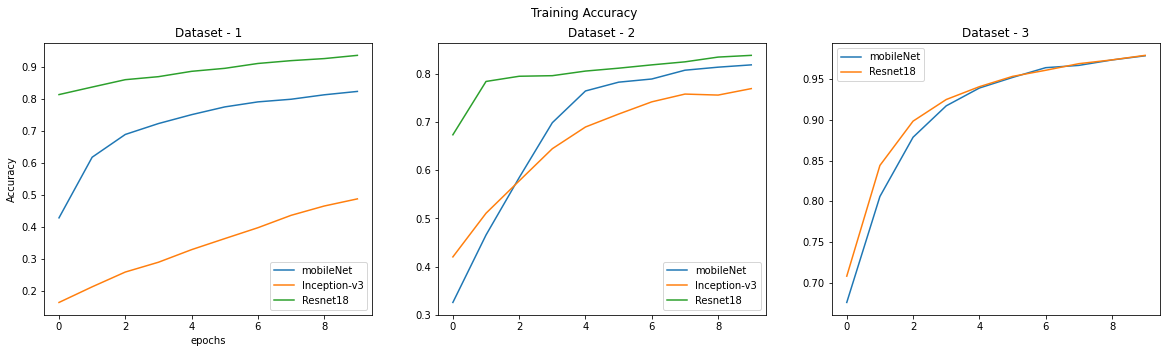

In [34]:
import matplotlib.pyplot as plt

tomato = {'resnet': [0.81387341, 0.83743423, 0.86056948, 0.87000929, 0.88676106, 0.89612349, 0.91136645, 0.92018725,
                     0.9266481, 0.93678428],
          'inception': [0.16266295313835144, 0.21159721910953522, 0.25793972611427307, 0.2886542081832886,
                        0.32811108231544495, 0.3626938760280609, 0.3968124985694885, 0.4355730712413788,
                        0.4647789001464844, 0.4871378242969513],
          'mobileNet': [0.42769266, 0.61764933, 0.68898948, 0.72311204, 0.75100588, 0.77526308, 0.79100898, 0.79928815,
                        0.81321572, 0.82377747]}
corn = {'mobileNet': [0.32544910179640716,
                      0.4655688622754491,
                      0.5847305389221557,
                      0.6988023952095809,
                      0.7646706586826348,
                      0.782934131736527,
                      0.7895209580838323,
                      0.8077844311377245,
                      0.8140718562874251,
                      0.8188622754491018],
        'inception': [0.4200477600097656, 0.5107462406158447, 0.5779104232788086, 0.6447761058807373,
                      0.6898507475852966, 0.7167164087295532, 0.7420895099639893, 0.7582089304924011,
                      0.7561193704605103, 0.7695522308349609], 'resnet': [0.6736526946107784,
                                                                          0.7844311377245509,
                                                                          0.7952095808383234,
                                                                          0.7964071856287426,
                                                                          0.8059880239520957,
                                                                          0.8119760479041916,
                                                                          0.8188622754491018,
                                                                          0.8251497005988024,
                                                                          0.8350299401197604,
                                                                          0.838622754491018]}
plant = {'mobileNet': [0.6755557006234292, 0.8057903841759963, 0.878610830042106, 0.9171916310343703, 0.939093253255867,
                       0.9520840813395567, 0.9640957012762347, 0.9669027646310018, 0.9735940203022489,
                       0.9787185429382772],
         'resnet': [0.707869569474818, 0.8439468616378888, 0.898390834611744, 0.9249600156673303, 0.9407252668342201,
                    0.9533896922022392, 0.9608969546626628, 0.9690243822828606, 0.973659300845383, 0.9792407872833502]}
plot(tomato, corn, plant, "Training Accuracy")

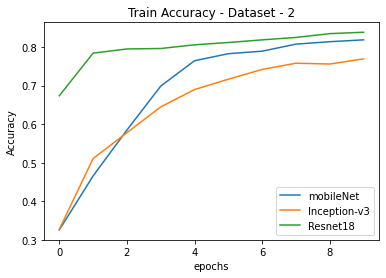

In [10]:
plt.plot(corn['mobileNet'], label="mobileNet")
plt.plot(corn['inception'], label="Inception-v3")
plt.plot(corn['resnet'], label="Resnet18")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracy - Dataset - 2")
plt.legend()


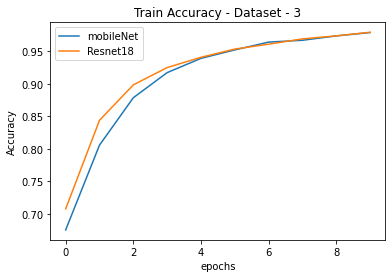

In [9]:
plt.plot(plant['mobileNet'], label="mobileNet")
plt.plot(plant['resnet'], label="Resnet18")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train Accuracy - Dataset - 3")
plt.legend()


In [32]:
def plot(tomato, corn, plant, title):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(title)
    ax[0].plot(tomato['mobileNet'], label="mobileNet")
    ax[0].plot(tomato['inception'], label="Inception-v3")
    ax[0].plot(tomato['resnet'], label="Resnet18")
    ax[0].set_title("Dataset - 1")
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(corn['mobileNet'], label="mobileNet")
    ax[1].plot(corn['inception'], label="Inception-v3")
    ax[1].plot(corn['resnet'], label="Resnet18")
    ax[1].set_title("Dataset - 2")
    ax[2].plot(plant['mobileNet'], label="mobileNet")
    ax[2].plot(plant['resnet'], label="Resnet18")
    ax[2].set_title("Dataset - 3")
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

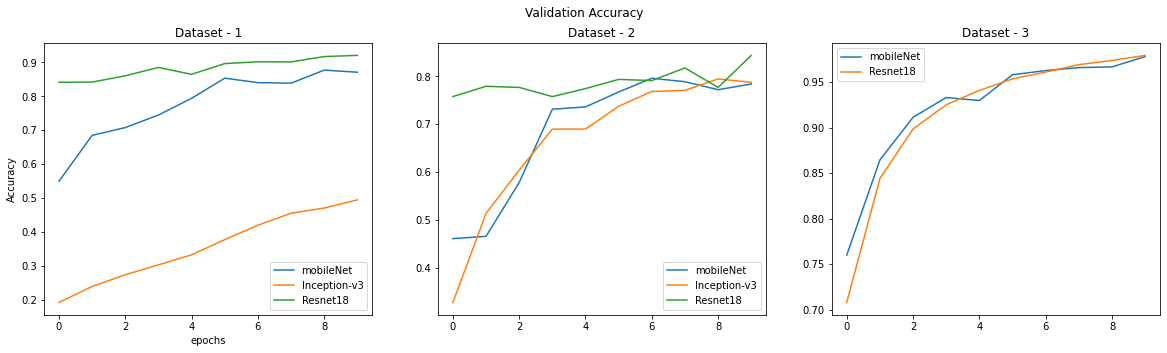

In [33]:
tomato = {'resnet': [0.8413886, 0.84198713, 0.86054167, 0.88523118, 0.86488104, 0.89660332, 0.90184049, 0.90154122,
                     0.91725273, 0.92084393],
          'inception': [0.19232554733753204, 0.23951725661754608, 0.2739439904689789, 0.30318737030029297,
                        0.33281758427619934, 0.37745627760887146, 0.42008355259895325, 0.45543864369392395,
                        0.47067925333976746, 0.494739294052124],
          'mobileNet': [0.5497531, 0.6850217, 0.70791561, 0.74487506, 0.79425408, 0.85365854, 0.84034116, 0.83884483,
                        0.87730061, 0.87116564]}
corn = {'mobileNet': [0.460431654676259,
                      0.4652278177458034,
                      0.5779376498800959,
                      0.7314148681055156,
                      0.73621103117506,
                      0.7673860911270984,
                      0.7961630695443645,
                      0.788968824940048,
                      0.7721822541966426,
                      0.7841726618705036],
        'inception': [0.32686567306518555, 0.5131264925003052, 0.6038186550140381, 0.6897374987602234,
                      0.6897374987602234, 0.7374702095985413, 0.7684964537620544, 0.7708830833435059,
                      0.7947494387626648, 0.7875895500183105], 'resnet': [0.7577937649880096,
                                                                          0.7793764988009592,
                                                                          0.776978417266187,
                                                                          0.7577937649880096,
                                                                          0.7745803357314149,
                                                                          0.7937649880095923,
                                                                          0.7913669064748201,
                                                                          0.8177458033573141,
                                                                          0.776978417266187,
                                                                          0.8441247002398082]}
plant = {
    'mobileNet': [0.7599216710182768, 0.8643603133159269, 0.9112271540469973, 0.9328981723237598, 0.9296344647519582,
                  0.9579634464751958, 0.962532637075718, 0.9657963446475196, 0.966579634464752, 0.9779373368146214],
    'resnet': [0.707869569474818, 0.8439468616378888, 0.898390834611744, 0.9249600156673303, 0.9407252668342201,
               0.9533896922022392, 0.9608969546626628, 0.9690243822828606, 0.973659300845383, 0.9792407872833502]}

plot(tomato, corn, plant, "Validation Accuracy")

In [29]:
!pip install ptflops

In [24]:
import time
import torch
import torchvision.models as models
from ptflops import get_model_complexity_info

# Define the path to your saved model file
model_path = '/kaggle/input/model/pytorch/corn-maize-model-hp/1/model.pth'

# Define the model architecture (assuming it's the same as when it was saved)
model = models.inception_v3()  # Replace with your model architecture

# Load the model's state dictionary
state_dict = torch.load(model_path)

# Load the state dictionary into the model
# model.load_state_dict(state_dict)

# Ensure to set the model to evaluation mode
model.eval()

# If needed, move the model to the desired device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define your data loader and criterion if necessary
# train_loader = ...
# criterion = ...
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Define input tensor (replace this with an actual input from your dataset)
# For FLOPs calculation, the input tensor shape should match your model's input shape
input_tensor = torch.randn(1, 3, 224, 224).to(device)  # assuming input size is (batch_size, channels, height, width)

# Measure wall clock time for one epoch
start_time = time.time()

# Run one epoch (loop over data loader)
for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

end_time = time.time()
epoch_time = end_time - start_time
print(f"Wall clock time for one epoch: {epoch_time} seconds")

Wall clock time for one epoch: 62.71530532836914 seconds


In [32]:
from ptflops import get_model_complexity_info

macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Inception3(
  27.16 M, 100.000% Params, 2.85 GMac, 99.527% MACs, 
  (Conv2d_1a_3x3): BasicConv2d(
    928, 0.003% Params, 11.43 MMac, 0.399% MACs, 
    (conv): Conv2d(864, 0.003% Params, 10.65 MMac, 0.372% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(64, 0.000% Params, 788.54 KMac, 0.028% MACs, 32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    9.28 k, 0.034% Params, 110.26 MMac, 3.852% MACs, 
    (conv): Conv2d(9.22 k, 0.034% Params, 109.5 MMac, 3.826% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, 0.000% Params, 760.38 KMac, 0.027% MACs, 32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    18.56 k, 0.068% Params, 220.51 MMac, 7.705% MACs, 
    (conv): Conv2d(18.43 k, 0.068% Params, 218.99 MMac, 7.651% MACs, 32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d

In [33]:
2.86*2

5.72